# **IEOR E4650  Business Analytics (Fall 2019)**

##**Lecture 6: Poisson Model**

In this lecture, we discuss how to model outcome variables that measures the number of occurances. 

Learning objective:

* Understand the basics of MLE
* Understand how to estimate a Poisson model
* Understand how to use Poisson model for prediction



##Setting of the study

As a marketing manager, you are interested in measuring the effectiveness of your ads. The specific job is as following: when a user comes to a website, you bid to show an ad. If you win the bid, the user is shown an advertisement. If the users does not even show up on that website, you cannot show the advertisement. By the end of the day, you will have some customers who never saw our advertisement, saw our advertisement only once, and saw our advertisement multiple times. We are interested in modeling how much customers are engaged with our advertisement. This could be a very critical measurement for our bidding budget.

Thus, it is important to measure the effectiveness of your campaign. Some commonly used measurements can be:

1.Reach: proportion of users who have seen the advertisement at least once

2.Frequency: average number of exposure for those who have seen it

3.Gross rating points (GRPs) : average number of exposues per 100 users in the market

4.Impression: How many times an advertisement is fetched

...


## How is user online behavior data is collected?

This type of data could be collected using "[HTTP cookies](https://en.wikipedia.org/wiki/HTTP_cookie)". This cookie will identify a specific browser. Based on the cookie, the websites can track the behaviors performed on the browser. This has been used to by companies to collect data about consumers and commonly used for targeted advertisement.

The HTTP cookie transaction has become a lucrative business itself. Here is an [interesting article ](https://www.fastcompany.com/90310803/here-are-the-data-brokers-quietly-buying-and-selling-your-personal-information)that discusses this market. 

## Dataset

We start with 5000 cookies (users) and show an advertisement to the users associated with these cookies. For each cookie, we are measuring how many times an user is exposed to the advertisement. The data gives the number of expressions for each cookie within one day.

By the end of the day, we have two columns that show the following: 

Cookie_ID: The ID of a cookie (The original cookie id is replaced by a sequence number)

Exposures: How many times this cookie is exposed to an advertisement.
 

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link="https://drive.google.com/open?id=1pjdoOKuczV8Zc6Zw8-yUh6q2tqogN-xt"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile.csv')  
import pandas as pd
import numpy as np
Exposure = pd.read_csv('myfile.csv')
Exposure.head(10)



,Cookie_ID,Exposures
0,1,0
1,2,0
2,3,3
3,4,49
4,5,4
5,6,1
6,7,5
7,8,0
8,9,7
9,10,27


##Question

Can we use this model do predict how many times the users will clicking our dataset if the advertisement is shown for 3 days instead of just 1 day?

## Data Generating process

Here we are interested in modeling the number of times an individual sees the ads on a given day. 

This occurances of exposures is usually modeled by a Poisson process. For a Poisson process, the number of arrivals within a time frame follows a Poisson distribution with $E(\lambda)$, where $\lambda$ is the expected number of arrivals within the time frame. 


In addition, if the arrival rate is constant, we have a homogeneous Poisson process, which has the inter-arrival time following an exponential distribution. For a homogeneous process, the arrival rate $\lambda$ is constant. For a non-homogeneous process, the $\lambda$ can vary with time.

Thus, if we want to model the number of exposures within a day, we can assume 
$$y \sim Poisson(\lambda)$$

We want to use the data to recover the value for $\lambda$, which is the expected number of arrivals within a day. Notice that, this specification does not rely on the assumption of whether the arrival process is homogeneous or non-homogeneous since we are only modeling the expected number of occurances within one day not the time of exposure. 

## Estimating the distribution

We will use **Maximum Likelihood Estimation (MLE)** technique to recover the value for $\lambda$. The idea of MLE is very simple, we would like to construct a value that indicate how likely it is to observe the outcomes (we call this **likelihood**) given the parameters. We will then choose the value of parameters (in our case, $\hat{\lambda}$) to maximize this likelihood.


The steps of implementation is as follows:

1. Calculate individual likelihood
> Each observation will have its likelihood of appearing. In our case, it is nothing but the probability of observing the outcome give $\lambda$, which is the PMF of a Poisson distribution. $$P(y_i|\lambda)=\frac{exp(\lambda)\lambda^y_i}{y_i!}$$.

2. Calculate the joint likelihood 

In a dataset, we have many observations. We would like to compute how likely it is to observe the outcomes at the same time. The likelihood to observe all the outcomes at the same time follows:
$$\prod P(y_i|\lambda) $$

Our task is simply to find $\lambda$ to maximize the joint likelihood.

However, in practice, multiplying many probabilities together will lead the product to be extremely close to zero, which can be computationally challenging. Thus, in practice, people choose to maximize the joint log likelihood

$$log(\prod P(y_i|\lambda))=\sum log(P(y_i|\lambda)) $$

Thus, what we are doing is as follows:

1. Calculate the individual log likelihood

In our case, it is $log(P(y_i|\lambda))=log(\frac{exp(\lambda)\lambda^y_i}{y_i!})$

2. Sum of all the individual log likelihood together 

3. Choose a good algorithm to find $\lambda$ to maximize the joint log likelihood.



###Compute the joint log likelihood for this data


In [0]:
import scipy.special as spsp


In [0]:

def LL(lmbda):
  Exposures=Exposure["Exposures"].values
  #individual log likelihood
  ind_L= np.exp(-lmbda)*lmbda**Exposures/spsp.factorial(Exposures)
  ind_LL=np.log(ind_L)
  #joint log likelihood
  Joint_LL=np.sum(ind_LL)
  return Joint_LL

LL(0.01)

-76781.21943620704

### Maximization

We will rely on a search algorithm to help us find the maximum. Python has implemented many optimization algorithms. We will rely on the algorithms to help us find the best $\lambda$.

<div>
<img src="https://slideplayer.com/slide/781164/3/images/7/Maximum+Likelihood+Estimation%3A.jpg
" width="450"/>
</div> 


However, it is important to notice that in some cases, the model might converge to a local maximum. We will need to try different starting points to make sure that we are finding a point that is close to the global maximum.

###Implementation 

* There is no maximization function we can use. We can only do minimization using [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function.  Thus, we will minimize the negative of joint log likelihood. 

* The $\lambda$ can only be positive. To avoid putting constraint on the parameters (which can make the optimization more difficult), we will replace $\lambda$ by $exp(\beta)$. 

In [0]:
import scipy.stats as spst
Exposures=Exposure["Exposures"].values

def neg_LL(beta):
  lmbda=np.exp(beta)
  #individual log likelihood
  ind_LL=np.log(spst.poisson.pmf(Exposures,lmbda))
  #joint log likelihood
  Joint_LL=np.sum(ind_LL)
  return -Joint_LL

neg_LL(-1)


33149.07746880029

We will use [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function inside `scipy.optimize` to minimize the negative joint log likelihood 

In [0]:
from scipy.optimize import minimize

Here we will use (Broyden–Fletcher–Goldfarb–Shanno ) [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs) method for minimization. This method is one of the most commonly used methods for unconstrained nonlinear optimization problem. [Also used by many built-in functions in Python]

In [0]:
#randomly select a starting point
guess=np.random.rand()
#start minimization
result=minimize(neg_LL, guess, method="BFGS")
beta=result.x
lmbda=np.exp(beta)
print(beta,lmbda)

[0.92417952] [2.51979996]


In [0]:
np.mean(Exposure["Exposures"])

2.5198

Let's try a different optimization algorithm "Nelder-Mead"

In [0]:
minimize(neg_LL,guess, method="Nelder-Mead").x

array([0.92416426])

As a comparison, we will also fit a Poisson model using the build-in function. 

In [0]:
from statsmodels.formula.api import poisson
#define the poisson model 
model= 
print(model.summary())
#recover lambda_hat
lambda_hat= 

###How well is the model performance?

Here, we are not really interested in the individual prediction. Here, if we predicted the expected number of exposures, everyone will get $\hat{\lambda}$. However, we can predict how the whole market is performing and compare with the actual data.

After knowing that $\lambda$ is equal to 2.5198. We can recover P(y=0), P(y=1),...

Following this, we predict the expected number of cookies having exposures equals 0, 1, 2,.. by simply calculating 

5000 * P(y=0), 5000 * P(y=1),....

In addition, we know in the actual data set, how many cookies had 0 exposures, 1 exposures, .. We can see how well they match with each other.

In [0]:
Tally=Exposure.groupby(["Exposures"]).count()
Exposures=Tally.index.values
Counts= Tally.iloc[:,0].values
Predicted_Exposures= np.arange(np.min(Exposures),np.max(Exposures)+1)
#Exposures
Predicted_counts= spst.poisson.pmf(Predicted_Exposures,lmbda)*5000
Predicted_counts
#Tally

array([4.02378516e+02, 1.01391337e+03, 1.27742944e+03, 1.07295555e+03,
       6.75908339e+02, 3.40630761e+02, 1.43053563e+02, 5.14951948e+01,
       1.62196988e+01, 4.54115515e+00, 1.14428026e+00, 2.62123396e-01,
       5.50415436e-02, 1.06687446e-02, 1.92022159e-03, 3.22571619e-04,
       5.08009971e-05, 7.52990298e-06, 1.05410274e-06, 1.39796212e-07,
       1.76129246e-08, 2.11338317e-09, 2.42059220e-10, 2.65191659e-11,
       2.78429138e-12, 2.80634293e-13, 2.71977800e-14, 2.53825797e-15,
       2.28425084e-16, 1.98477765e-17, 1.66708088e-18, 1.35506785e-19,
       1.06703123e-20, 8.14759165e-22, 6.03832387e-23, 4.34724807e-24,
       3.04283209e-25, 2.07225087e-26, 1.37412044e-27, 8.87822724e-29,
       5.59283917e-30, 3.43727706e-31, 2.06220253e-32, 1.20845066e-33,
       6.92057713e-35, 3.87521555e-36, 2.12277566e-37, 1.13807873e-38,
       5.97443903e-40, 3.07232475e-41, 1.54832876e-42, 7.64995833e-44,
       3.70699321e-45, 1.76243045e-46, 8.22402255e-48, 3.76779849e-49,
      

5000

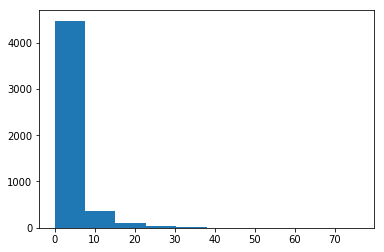

In [0]:
import matplotlib.pyplot as plt
plt.hist(Exposures)
len(Exposures)

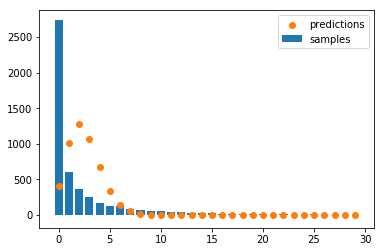

In [0]:
import matplotlib.pyplot as plt
plt.bar(Exposures[Exposures<30], Counts[Exposures<30],label="samples")
plt.scatter(Predicted_Exposures[Predicted_Exposures<30], Predicted_counts[Predicted_Exposures<30],zorder=2,label="predictions")
plt.legend(loc="best")
plt.show()

They do not line up with either other well... :(

## Use the model for prediction

Can we use this model to predict how many of these customers will have 0, 1, 2, 3, ... exposures if they are exposured for 3 days instead of just 1 day?

$$p(y|t*\lambda)=\frac{exp(t\lambda)(t\lambda)^x}{x!}$$

In [0]:
#3 unit of time

(spst.poisson.pmf(Predicted_Exposures,3*lmbda)*5000)[0:10]

array([  2.6059396 ,  19.69933951,  74.45759246, 187.61823879,
       354.57032349, 536.06777298, 675.39177748, 729.36521848,
       689.19541917, 578.87819743])

In [0]:
(spst.poisson.pmf(Predicted_Exposures,lmbda)*5000)[0:10]

array([ 402.37851596, 1013.91336996, 1277.42943647, 1072.95554926,
        675.90833855,  340.6307614 ,  143.05356338,   51.49519483,
         16.21969876,    4.54115515])